In [1]:
from __future__ import print_function, division
import sys
import copy
import os
import datetime
import time
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torch
import os

plt.ion()   # interactive mode

In [2]:
# path of weights transfered from CCV
PATH = "weights/student_CUB200_Dec4"

In [3]:
# for compatibility with old code
is_local = True

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset_name = "CUB_200"
data_dir = f"datasets/{dataset_name}" if is_local else f"/users/tjiang12/data/tjiang12/{dataset_name}"
dataset = datasets.ImageFolder(data_dir, data_transforms['train'])

val_size = int(0.3 * len(dataset))
train_size = len(dataset) - val_size

train_and_val = torch.utils.data.random_split(dataset, [train_size, val_size])

image_datasets = dict(zip(['train', 'val'], train_and_val))
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [classname.split('.')[1].replace('_', ' ') for classname in dataset.classes]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                pred_status = "✔" if preds[j] == labels[j] else "✘, " + class_names[labels[j]]
                ax.set_title('{} ({})'.format(class_names[preds[j]], pred_status))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
model_loaded = models.resnet50()
num_ftrs = model_loaded.fc.in_features
model_loaded.fc = nn.Linear(num_ftrs, len(class_names))

model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

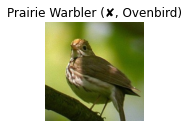

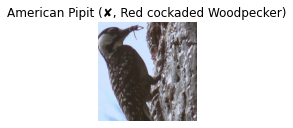

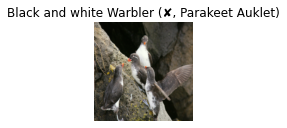

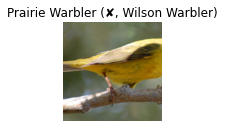

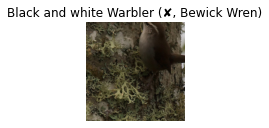

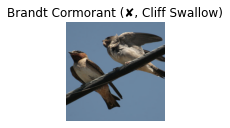

In [9]:
visualize_model(model_loaded)